# Projet 7 - Implémentez un modèle de scoring
# Notebook de modélisation
Dans ce notebook j'ai déjà selectionné la méthode pour modéliser (Régression Logistique), le feature engineering (données de base avec features propres au domaine bancaire).
Maintenant il me reste à  :
- créer une fonction qui dégage des données brutes le feature engineering
- voir quel est le meilleur seuil pour maximiser ma fonction de cout

# <a name="C0">SOMMAIRE</a>

### <a href="#C1">1. Set up Environnement</a>
### <a href="#C2">2. Fonction Feature Engineering </a>
### <a href="#C3">3. Seuil de détection de Faillite bancaire </a>
### <a href="#C4">4. Interprétation du modèle</a>
### <a href="#C5">5. Data Drift </a>
### <a href="#C6">6. Import pour Dashboard </a>


# Les données & Source

Source : [Home Credit](http://www.homecredit.net/about-us.aspx)


### TRACKING ML FLOW UI
dans anaconda prompt :  mlflow ui
dans navigateur : http://127.0.0.1:5000


# <a name="C1">1. Set up environnement</a>
<a href="#C0">SOMMAIRE</a>

### Imports des librairies et chargement des données

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

#tracking results
import mlflow
import mlflow.sklearn

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#Chargement des données
#chargement des données d'entraînement
data = pd.read_csv('Source/application_train.csv')

# <a name="C2">2. Fonction Feature Engineering</a>
<a href="#C0">SOMMAIRE</a>

In [3]:
def feature_engineering(data):
    #label encoding
    data_col_le=['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
    mapping = {'NAME_CONTRACT_TYPE': {'Cash loans': 0,'Revolving loans': 1},
    'FLAG_OWN_CAR': {'N': 0,'Y': 1},'FLAG_OWN_REALTY': {'N': 0,'Y': 1},'EMERGENCYSTATE_MODE': {'No': 0,'Yes': 1,'nan': 2}}
    for col in data.columns:
        if col in data_col_le:
            encoding_map = mapping[col]
            data[col] = data[col].map(encoding_map).fillna(data[col])
    # one-hot encoding of categorical variables
    categorical_cols=['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']
    data = pd.get_dummies(data)
    print('Data Features shape: ', data.shape)
    anom = data[data['DAYS_EMPLOYED'] == 365243]
    non_anom = data[data['DAYS_EMPLOYED'] != 365243]
    print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
    print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
    print('There are %d anomalous rows for days of employment' % len(anom))
    print("%0.2f%% des données sont concernées par l'anomalie" % (len(anom)/len(data)*100))
    # Create an anomalous flag column
    data['DAYS_EMPLOYED_ANOM'] = data["DAYS_EMPLOYED"] == 365243

    # Replace the anomalous values with nan
    data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    #abs data birth
    data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
    
    #data domain features
    data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    print('Data Features shape: ', data.shape)
    return data


In [4]:
data_FE= feature_engineering(data)

Data Features shape:  (307511, 242)
The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous rows for days of employment
18.01% des données sont concernées par l'anomalie
Data Features shape:  (307511, 247)


In [5]:
#engineering pour fitting du modèle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

y=data_FE['TARGET']
ids=data_FE['SK_ID_CURR']
X = data_FE.drop(['TARGET','SK_ID_CURR'], axis=1)
# Effectuer la division train/test
X_train, X_test, y_train, y_test, _, ids_test = train_test_split(X, y, ids, test_size=0.2, random_state=42)
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)
ids_test.reset_index(drop=True, inplace=True)

# Vérifier les tailles des ensembles de données
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))

# Feature names
features = list(X.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Taille de l'ensemble d'entraînement : 246008
Taille de l'ensemble de test : 61503
Training data shape:  (246008, 245)
Testing data shape:  (61503, 245)


In [6]:
# création d'un sous ensemble plus petit si trop long
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", X_train_small.shape)

Nouvelle taille de l'échantillon d'entraînement : (73802, 245)


# <a name="C3">3. Seuil de détection de Faillite bancaire </a>
<a href="#C0">SOMMAIRE</a>

On va utiliser des fonctions pour rechercher de façon plus approndie les meilleurs hyperparamètres. 
Ensuite on va fitter le modèle sur la partie train, et sur la partie test étudier la possibilité de différents seuils de détection et voir le score correspondant ( que l'on cherche à maximiser).

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, confusion_matrix, auc, roc_curve

def evaluate_model_cost_function(model, params, X_train, y_train, X_test, y_test,cost_scorer):
    # recherche hyperparams avec GridSearchCV et Cross Validation
    grid_search = GridSearchCV(model, params, scoring=cost_scorer, cv=5)
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres et le meilleur modèle
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Évaluer les performances sur l'ensemble de test
    y_pred = best_model.predict(X_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_model = roc_auc_score(y_test, y_scores)
    cm = confusion_matrix(y_test, y_pred)
    cost_score = cost_function(y_test, y_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres :", best_params)
    print("Recall :", recall)
    print("F1-score :", f1)
    print("AUC ROC :", auc_model)
    print("Cost Function :", cost_score)
    print("Matrice de confusion :\n", cm)

    # Calculer la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Afficher la courbe ROC
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')  # Droite AUC-ROC (aléatoire)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC ')
    plt.legend(loc="lower right")
    plt.show()
    
    #stocker les resultats
    results = [str(best_model),str(round(recall,5)),str(round(f1,5)),str(round(auc_model,5)),str(round(cost_score,5))]

    # Retourner le meilleur modèle
    return best_model, results, cm, best_params, y_scores 


def cost_function(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    tn = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    total_cost = tn * 1 - fp * 1 - fn * 10
    return total_cost


from sklearn.metrics import make_scorer

cost_scorer = make_scorer(cost_function, greater_is_better=True)

#fonction save experience in ML avec cost function
def trackwithmlcostfunction(results,params,donnees,balanced) :
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.autolog(disable=True) 
    mlflow.set_experiment("Seuil de detection LR ")
    #balanced = yes or no
    name = results[0]
    recall = results[1]
    f1 = results[2]
    auc_model = results[3]
    cost_score=results[4]
    feature_engineering_type = donnees
    with mlflow.start_run(run_name=name):
        mlflow.log_params(params)
        mlflow.log_metric("roc_auc", auc_model)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_param("Feature Engineering", feature_engineering_type)
        mlflow.log_param("Balanced", balanced)
        mlflow.log_metric("Cost Score", cost_score)
    mlflow.end_run()
    print('Model '+name+' with '+feature_engineering_type+' /balanced : '+balanced+' == DONE')

### Recherche des meilleurs hyperparamètres sur la regression logistique sur une petite portion du dataset
en utilisant notre propre scorer en fonction de la problématique métier

Meilleurs hyperparamètres : {'C': 0.7, 'solver': 'lbfgs'}
Recall : 0.6611436653869469
F1-score : 0.255485281486687
AUC ROC : 0.7441684257832837
Cost Function : -30891
Matrice de confusion :
 [[39161 17393]
 [ 1677  3272]]


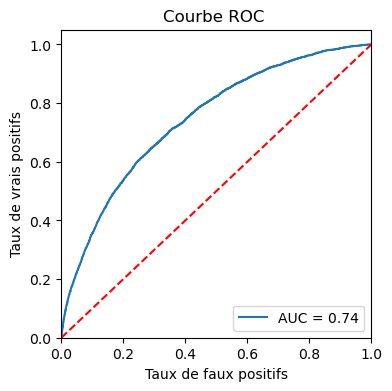

In [8]:
#import
from sklearn.linear_model import LogisticRegression

# define model
model = LogisticRegression(class_weight='balanced')

#define params
params = {'C': [0.7,0.55,0.4,0.1,0.01],
         'solver': ['lbfgs']}

logreg_best,logreg_results,logreg_cm, logreg_params,logreg_scores = evaluate_model_cost_function(model,params,X_train_small,y_train_small,X_test,y_test,cost_scorer)

In [9]:
def seuil_detection(y_scores, seuil, y_true):
    y_pred = np.where(y_scores < seuil, 0, 1)
    score = cost_function(y_true, y_pred)
    return score


In [10]:
logreg_best.fit(X_train,y_train)

LogisticRegression(C=0.7, class_weight='balanced')

In [11]:
logreg_scores = logreg_best.predict_proba(X_test)[:, 1]

In [12]:
#stockage des différents seuil à tester
values = np.arange(0, 1.01, 0.01).tolist()
results = [] 

for seuil in values:
    score = seuil_detection(logreg_scores,seuil,y_test)
    results.append([seuil, score])

# Conversion de la liste en dataframe
df = pd.DataFrame(results, columns=['seuil', 'score'])

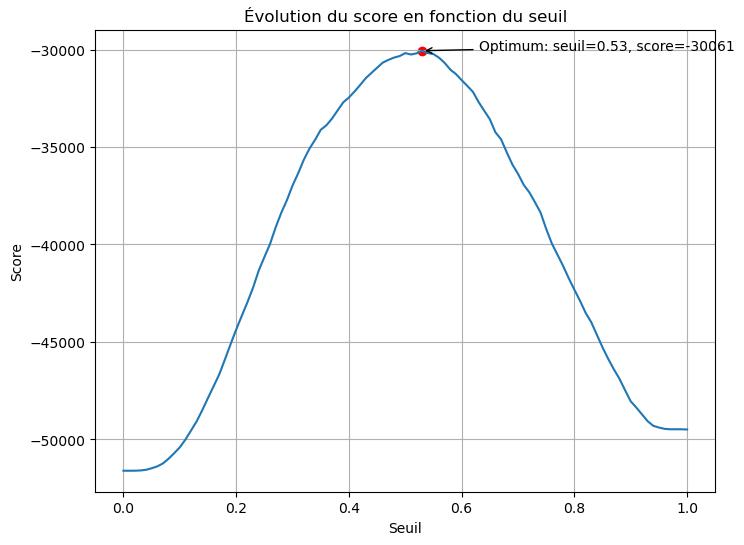

In [13]:
import matplotlib.pyplot as plt

# Tracer la courbe
plt.figure(figsize=(8, 6))
plt.plot(df['seuil'], df['score'])
plt.xlabel('Seuil')
plt.ylabel('Score')
plt.title('Évolution du score en fonction du seuil')
plt.grid(True)

# Trouver l'optimum
optimum = df[df['score'] == df['score'].max()]
seuil_optimum = optimum['seuil'].values[0]
score_optimum = optimum['score'].values[0]

# Afficher l'optimum sur le graphique
plt.scatter(seuil_optimum, score_optimum, color='red')
plt.annotate(f"Optimum: seuil={seuil_optimum}, score={score_optimum}",
             xy=(seuil_optimum, score_optimum),
             xytext=(seuil_optimum + 0.1, score_optimum - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()



In [14]:
#stockage des différents seuil à tester
values = np.arange(0.52, 0.54, 0.001).tolist()
results = [] 

for seuil in values:
    score = seuil_detection(logreg_scores,seuil,y_test)
    results.append([seuil, score])

# Conversion de la liste en dataframe
df = pd.DataFrame(results, columns=['seuil', 'score'])

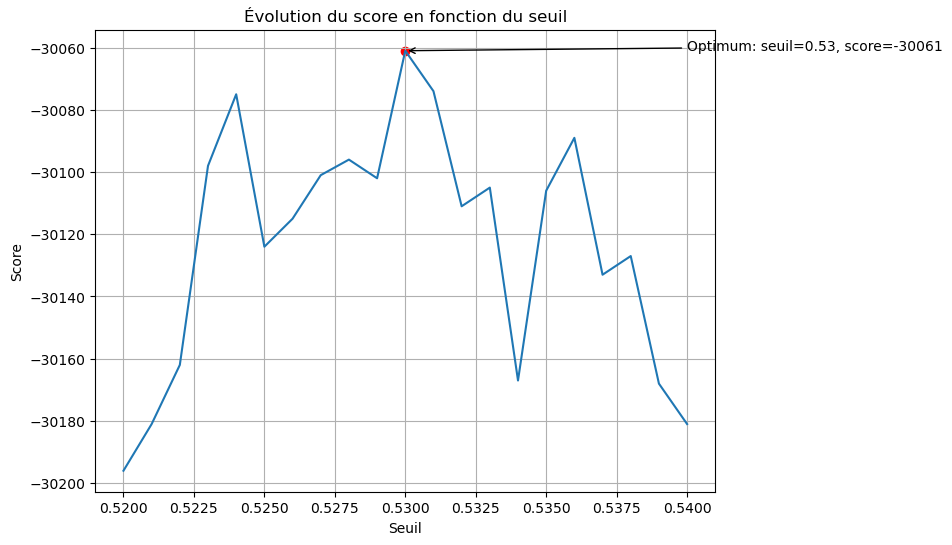

In [15]:
# Tracer la courbe
plt.figure(figsize=(8, 6))
plt.plot(df['seuil'], df['score'])
plt.xlabel('Seuil')
plt.ylabel('Score')
plt.title('Évolution du score en fonction du seuil')
plt.grid(True)

# Trouver l'optimum
optimum = df[df['score'] == df['score'].max()]
seuil_optimum = optimum['seuil'].values[0]
score_optimum = optimum['score'].values[0]

# Afficher l'optimum sur le graphique
plt.scatter(seuil_optimum, score_optimum, color='red')
plt.annotate(f"Optimum: seuil={seuil_optimum}, score={score_optimum}",
             xy=(seuil_optimum, score_optimum),
             xytext=(seuil_optimum + 0.01, score_optimum - 0.01),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

Recall : 0.6362901596282077
F1-score : 0.2702076540243693
AUC ROC : 0.7487552224256536
Cost Function : -30061
Matrice de confusion :
 [[41344 15210]
 [ 1800  3149]]


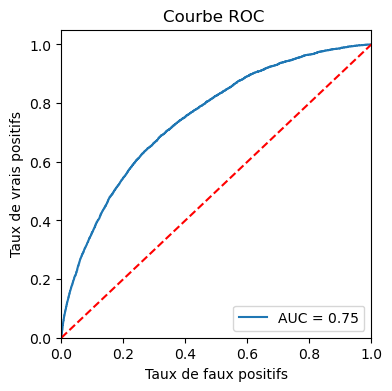

In [16]:
y_predict = (logreg_scores >= 0.53).astype(int)
recall = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
auc_model = roc_auc_score(y_test, logreg_scores)
cm = confusion_matrix(y_test, y_predict)
cost_score = cost_function(y_test, y_predict)

# Afficher les résultats
print("Recall :", recall)
print("F1-score :", f1)
print("AUC ROC :", auc_model)
print("Cost Function :", cost_score)
print("Matrice de confusion :\n", cm)

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, logreg_scores)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')  # Droite AUC-ROC (aléatoire)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC ')
plt.legend(loc="lower right")
plt.show()

Nous avons trouvé le meilleur seuil 0.53.
Maintenant nous allons passer à l'inteprétation du modèle.

# <a name="C4">4. Interprétation du modèle </a>
<a href="#C0">SOMMAIRE</a>


In [49]:
data_FE_columns = data_FE.columns.to_list()
data_FE_columns.remove('SK_ID_CURR')
data_FE_columns.remove('TARGET')

import shap

# Calcul des valeurs SHAP
explainer = shap.Explainer(logreg_best, X_train)
shap_values = explainer.shap_values(X_test)



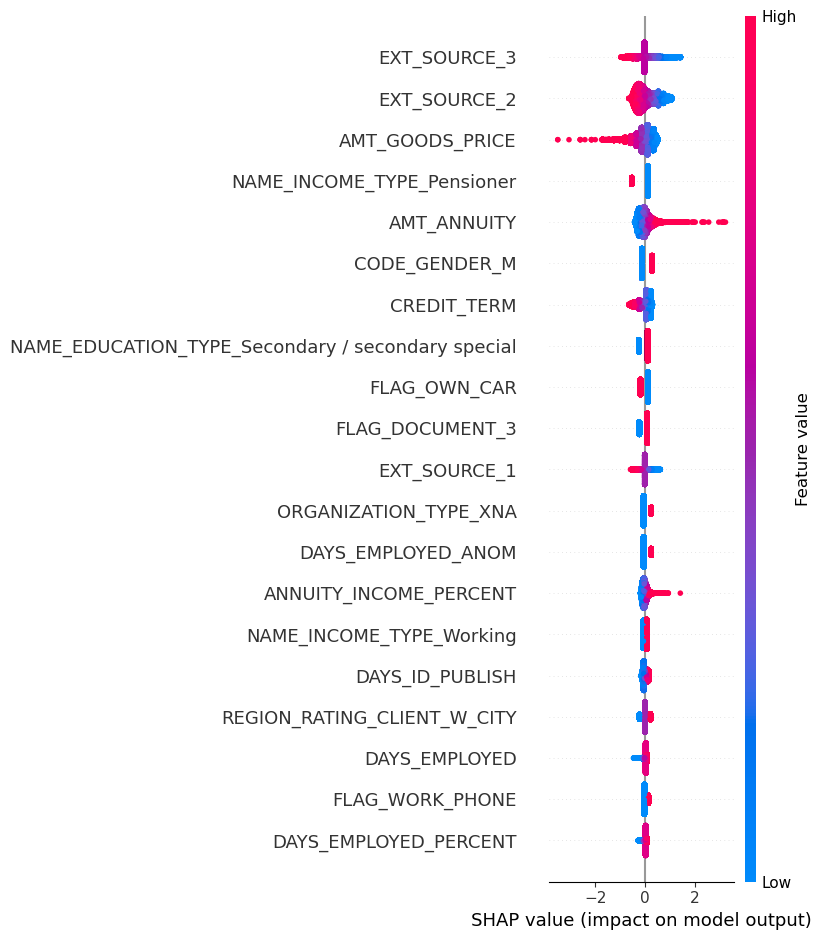

In [50]:
shap.summary_plot(shap_values, X_test, feature_names=data_FE_columns)

In [56]:
shap.initjs()

# Obtenir les index du score maximum et minimum
max_score_index = logreg_scores.argmax()
min_score_index = logreg_scores.argmin()

# Graphique de force SHAP pour le maximum score
shap.force_plot(explainer.expected_value, shap_values[max_score_index,:], X_test[max_score_index,:], feature_names=data_FE_columns)



In [57]:
# Graphique de force SHAP pour le minimum score
shap.force_plot(explainer.expected_value, shap_values[min_score_index,:], X_test[min_score_index,:], feature_names=data_FE_columns)


# <a name="C5">5. Data Drift </a>
<a href="#C0">SOMMAIRE</a>

In [61]:
data.DAYS_ID_PUBLISH.sort_values()


128073   -7197
139387   -6551
167492   -6383
111706   -6337
175941   -6274
          ... 
20354        0
149817       0
251874       0
86452        0
243336       0
Name: DAYS_ID_PUBLISH, Length: 307511, dtype: int64

In [65]:
import pandas as pd
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report

datapourdrift = pd.read_csv('Source/application_train.csv')
datapourdrift=datapourdrift.sample(20000)
datapourdrift = datapourdrift.sort_values('DAYS_ID_PUBLISH')
split_index = len(datapourdrift) // 2
reference = datapourdrift.iloc[:split_index]
current = datapourdrift.iloc[split_index:]

report = Report(metrics=[
    DataDriftPreset(),
])

report.run(reference_data=reference, current_data=current)

# Générer le rapport
report.save_html('datadrift_report2.html')  

# <a name="C6">6. Import pour Dashboard </a>
<a href="#C0">SOMMAIRE</a>


In [19]:
import pickle
#sauvegarde des shap values
#shap_values_part1 = shap_values[:len(shap_values)//2]
#shap_values_part2 = shap_values[len(shap_values)//2:]
#np.save('shap_values_part1.npy', shap_values_part1)
#np.save('shap_values_part2.npy', shap_values_part2)
#ids_test pour shap
#pickle.dump(ids_test,open('ids_test.pkl','wb'))
#imputer
#scaler
#logreg_best
#data_FE_columns